In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

'''

    RUMORE CsI + FUNZIONI VARIE
    
'''

rumore = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Caratterizzazione Cristalli\BGO\Fondo BGO\BGO-fondo-newgate.CSV', sep=';')

channel_back = np.array(rumore['Channel']) #taglio i dati per avere lo stesso numero di elementi
counts_back = np.array(rumore['Counts'])
time_back = 9218 #s
frequency_back = counts_back/time_back

allungo_x = np.arange(20510, 1000000, 20)
allungo_y = np.zeros(len(allungo_x))
channel_back = np.concatenate((channel_back, allungo_x))
counts_back = np.concatenate((counts_back, allungo_y))
frequency_back = np.concatenate((frequency_back, allungo_y))

def frequency_converter(counts, time_signal=180, frequency_back=frequency_back, time_background=time_back, counts_back=counts_back):
    frequency = counts/time_signal
    counts_back = counts_back [:len(frequency)]
    frequency_ = frequency - frequency_back[:len(frequency)]
    for i in range(len(frequency_)):
        if frequency_[i] < 0:
            frequency_[i] = 0
    error = np.sqrt(counts/time_signal**2 + counts_back/time_background**2)
    return frequency_, error

def SNIP_algorithm(spectrum, iterations=40):
    spectrum_log = np.log(np.log(np.sqrt(spectrum + 1) + 1) + 1)
    n_added = iterations
    begin_list = np.ones(n_added) * spectrum_log[0]
    end_list = np.ones(n_added) * spectrum_log[-1]
    spectrum_log = np.concatenate((begin_list, spectrum_log, end_list))
    for k in range(1, iterations+1, 1):
        for i in range(len(spectrum_log[n_added:-n_added])):
            spectrum_log[i] = np.minimum(spectrum_log[i], 0.5 * (spectrum_log[i+k] + spectrum_log[i-k]))
    return (np.exp(np.exp(spectrum_log[n_added:-n_added])-1)-1)**2-1

# funzioni per fit
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import norm, chi2

def func(x, A, mu, sigma):
    return A * norm.pdf(x, mu, sigma)

def func2(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return A1 * norm.pdf(x, mu1, sigma1) + A2 * norm.pdf(x, mu2, sigma2)

intensità_511KeV = []
intensità_trapz_511KeV = []
err_intensità_511KeV = []
err_sistematico_511KeV = []

intensità_1274_5KeV = []
intensità_trapz_1274_5KeV = []
err_intensità_1274_5KeV = []
err_sistematico_1274_5KeV = []

In [2]:
'''

    ARIA 0cm

'''

segnale_0cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Aria\Data\0cm.csv', sep=' \t', engine='python')
channel_0 = np.array(segnale_0cm['Channel'])
counts_0 = np.array(segnale_0cm['Counts'])

# calculating frequency and removing background noise
N = 17
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])


# plot
fig = px.line(x=channel_0, y=frequency_0[0], error_y=frequency_0[1], title='Spettro Na con alluminio di spessore 0cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()


# fit
ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=17000, mu1=2200, sigma1=130, A2=31000, mu2=1850, sigma2=138)
ls.mask = (channel_0 > 1650) & (channel_0 < 2550)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [1600, 2600]
for i in range(len(channel_0)):
    if channel_0[i] > integral_extremes[0] and channel_0[i] < integral_extremes[1]:
        freq_integral.append(frequency_0[0][i])
        channel_integral.append(channel_0[i])

area_tot = m.values['A1'] + m.values['A2']
err_area_tot = np.sqrt(m.errors['A1']**2 + m.errors['A2']**2)

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {area_tot:.2f} ± {err_area_tot:.2f}')

intensità_511KeV.append(m.values['A1']+m.values['A2'])
intensità_trapz_511KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_511KeV.append(np.sqrt(m.errors['A1']**2+m.errors['A2']**2))


# calcolo errore sistematico DOWN
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N+1)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=17000, mu1=2200, sigma1=130, A2=31000, mu2=1850, sigma2=138)
ls.mask = (channel_0 > 1650) & (channel_0 < 2550)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N-1)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=17000, mu1=2200, sigma1=130, A2=31000, mu2=1850, sigma2=138)
ls.mask = (channel_0 > 1650) & (channel_0 < 2550)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 66.5 (χ²/ndof = 1.8)       │              Nfcn = 684              │
│ EDM = 0.000104 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  17.82e3  │  0.22e3   │            │            │         │         │       │
│ 1 │ mu1    │ 2.1869e3  │ 0.0015e3  │            │            │         │         │       │
│ 2 │ sigma1 │   127.1   │    0.7    │            │            │         │         │       │
│ 3 │ A2     │  3.38e3   │  0.23e3   │            │            │         │         │       │
│ 4 │ mu2    │  1.894e3  │  0.010e3  │            │            │         │         │       │
│ 5 │ sigma2 │    144    │     6     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 4.79e+04   -315.5    137.0  -0.05e6  -2.08e3 -1.209e3 │
│    mu1 │   -315.5     2.23     -0.9    328.2     14.0      8.0 │
│ sigma1 │    137.0     -0.9    0.482   -140.9     -6.0     -3.3 │
│     A2 │  -0.05e6    328.2   -140.9 5.11e+04   2.16e3  1.276e3 │
│    mu2 │  -2.08e3     14.0     -6.0   2.16e3     93.6       54 │
│ sigma2 │ -1.209e3      8.0     -3.3  1.276e3       54     34.3 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 21114.97
Area picco con integrale fit: 21203.82 ± 314.66


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 62.42 (χ²/ndof = 1.6)      │              Nfcn = 681              │
│ EDM = 3.06e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  17.67e3  │  0.28e3   │            │            │         │         │       │
│ 1 │ mu1    │ 2.1883e3  │ 0.0016e3  │            │            │         │         │       │
│ 2 │ sigma1 │   127.0   │    0.7    │            │            │         │         │       │
│ 3 │ A2     │  3.80e3   │  0.29e3   │            │            │         │         │       │
│ 4 │ mu2    │  1.901e3  │  0.012e3  │            │            │         │         │       │
│ 5 │ sigma2 │    154    │     7     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 7.56e+04   -436.5    176.4  -0.08e6  -3.17e3  -1.84e3 │
│    mu1 │   -436.5     2.67     -1.1    455.1     18.6     10.5 │
│ sigma1 │    176.4     -1.1    0.507   -182.2     -7.4     -4.0 │
│     A2 │  -0.08e6    455.1   -182.2 8.17e+04   3.31e3   1.94e3 │
│    mu2 │  -3.17e3     18.6     -7.4   3.31e3      136       80 │
│ sigma2 │  -1.84e3     10.5     -4.0   1.94e3       80     48.9 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 21468.14


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 75.98 (χ²/ndof = 2.0)      │              Nfcn = 711              │
│ EDM = 2.63e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  17.92e3  │  0.17e3   │            │            │         │         │       │
│ 1 │ mu1    │ 2.1856e3  │ 0.0013e3  │            │            │         │         │       │
│ 2 │ sigma1 │   127.2   │    0.7    │            │            │         │         │       │
│ 3 │ A2     │  2.99e3   │  0.18e3   │            │            │         │         │       │
│ 4 │ mu2    │  1.889e3  │  0.008e3  │            │            │         │         │       │
│ 5 │ sigma2 │    134    │     5     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 3.06e+04   -221.7    105.2 -0.030e6  -1.37e3     -795 │
│    mu1 │   -221.7     1.76     -0.8    229.7     10.3      5.9 │
│ sigma1 │    105.2     -0.8    0.449   -107.6     -4.8     -2.6 │
│     A2 │ -0.030e6    229.7   -107.6 3.19e+04   1.41e3      837 │
│    mu2 │  -1.37e3     10.3     -4.8   1.41e3     64.8       37 │
│ sigma2 │     -795      5.9     -2.6      837       37     24.1 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 20912.88
Errore statistico: 314.66
Errore sistematico: 277.63


In [3]:
# fit
N = 17
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=1700, mu1=5300, sigma1=400, A2=300, mu2=4200, sigma2=800)
ls.mask = (channel_0 > 4050) & (channel_0 < 5700)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [4800, 5700]
for i in range(len(channel_0)):
    if channel_0[i] > integral_extremes[0] and channel_0[i] < integral_extremes[1]:
        freq_integral.append(frequency_0[0][i])
        channel_integral.append(channel_0[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_1274_5KeV.append(m.values['A1'])
intensità_trapz_1274_5KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_1274_5KeV.append(m.errors['A1'])

# calcolo errore sistematico DOWN
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N+1)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=1700, mu1=5300, sigma1=400, A2=300, mu2=4200, sigma2=800)
ls.mask = (channel_0 > 4050) & (channel_0 < 5700)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N-1)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=1700, mu1=5300, sigma1=200, A2=500, mu2=4200, sigma2=230)
ls.mask = (channel_0 > 4050) & (channel_0 < 5700)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 114.4 (χ²/ndof = 1.5)      │              Nfcn = 283              │
│ EDM = 1.12e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  1.877e3  │  0.013e3  │            │            │         │         │       │
│ 1 │ mu1    │ 5.2847e3  │ 0.0016e3  │            │            │         │         │       │
│ 2 │ sigma1 │   198.5   │    1.5    │            │            │         │         │       │
│ 3 │ A2     │    432    │    24     │            │            │         │         │       │
│ 4 │ mu2    │  4.208e3  │  0.016e3  │            │            │         │         │       │
│ 5 │ sigma2 │    224    │    13     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │     181    -1.1     6.0 -0.02e3  0.01e3 -0.01e3 │
│    mu1 │    -1.1    2.59    -0.2     2.8    -1.1     1.8 │
│ sigma1 │     6.0    -0.2    2.21    -4.4     1.7    -2.8 │
│     A2 │ -0.02e3     2.8    -4.4     587 -0.31e3  0.27e3 │
│    mu2 │  0.01e3    -1.1     1.7 -0.31e3     251 -0.16e3 │
│ sigma2 │ -0.01e3     1.8    -2.8  0.27e3 -0.16e3     161 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 1832.22
Area picco con integrale fit: 1877.39 ± 13.44


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 111.6 (χ²/ndof = 1.5)      │              Nfcn = 312              │
│ EDM = 5.68e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  1.894e3  │  0.014e3  │            │            │         │         │       │
│ 1 │ mu1    │ 5.2839e3  │ 0.0016e3  │            │            │         │         │       │
│ 2 │ sigma1 │   199.6   │    1.5    │            │            │         │         │       │
│ 3 │ A2     │    458    │    26     │            │            │         │         │       │
│ 4 │ mu2    │  4.209e3  │  0.016e3  │            │            │         │         │       │
│ 5 │ sigma2 │    232    │    13     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │     182    -1.2     6.2 -0.03e3  0.01e3 -0.02e3 │
│    mu1 │    -1.2    2.59    -0.2     3.8    -1.5     2.3 │
│ sigma1 │     6.2    -0.2    2.24    -5.7     2.1    -3.5 │
│     A2 │ -0.03e3     3.8    -5.7     652 -0.34e3  0.29e3 │
│    mu2 │  0.01e3    -1.5     2.1 -0.34e3     257 -0.17e3 │
│ sigma2 │ -0.02e3     2.3    -3.5  0.29e3 -0.17e3     172 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale fit: 1893.59


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 116.6 (χ²/ndof = 1.5)      │              Nfcn = 204              │
│ EDM = 2.86e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  1.859e3  │  0.013e3  │            │            │         │         │       │
│ 1 │ mu1    │ 5.2857e3  │ 0.0016e3  │            │            │         │         │       │
│ 2 │ sigma1 │   197.3   │    1.5    │            │            │         │         │       │
│ 3 │ A2     │    409    │    23     │            │            │         │         │       │
│ 4 │ mu2    │  4.207e3  │  0.015e3  │            │            │         │         │       │
│ 5 │ sigma2 │    216    │    12     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │     180    -1.1     5.9 -0.01e3  0.01e3 -0.01e3 │
│    mu1 │    -1.1    2.59    -0.2     2.0    -0.8     1.3 │
│ sigma1 │     5.9    -0.2    2.18    -3.3     1.2    -2.1 │
│     A2 │ -0.01e3     2.0    -3.3     515 -0.28e3  0.23e3 │
│    mu2 │  0.01e3    -0.8     1.2 -0.28e3     235 -0.14e3 │
│ sigma2 │ -0.01e3     1.3    -2.1  0.23e3 -0.14e3     146 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale fit: 1859.00
Errore statistico: 13.40
Errore sistematico: 17.30


In [4]:
'''

    ARIA 0.4cm

'''

segnale_0_4cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Aria\Data\0.4cm.csv', sep=' \t', engine='python')
channel_0_4 = np.array(segnale_0_4cm['Channel'])
counts_0_4 = np.array(segnale_0_4cm['Counts'])

# calculating frequency and removing background noise
N = 14
frequency_0_4 = frequency_converter(counts_0_4, time_signal=300)
background_0_4 = SNIP_algorithm(frequency_0_4[0], iterations=N)
frequency_0_4 = (frequency_0_4[0] - background_0_4, frequency_0_4[1])

# plot
fig = px.line(x=channel_0_4, y=frequency_0_4[0], error_y=frequency_0_4[1], title='Spettro Na con alluminio di spessore 0.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()


# fit
ls = LeastSquares(channel_0_4, frequency_0_4[0], frequency_0_4[1], func2)
m = Minuit(ls, A1=7300, mu1=2200, sigma1=200, A2=2000, mu2=1920, sigma2=80)
ls.mask = (channel_0_4 > 1650) & (channel_0_4 < 2500)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [1600, 2600]
for i in range(len(channel_0_4)):
    if channel_0_4[i] > integral_extremes[0] and channel_0_4[i] < integral_extremes[1]:
        freq_integral.append(frequency_0_4[0][i])
        channel_integral.append(channel_0_4[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_511KeV.append(m.values['A1']+m.values['A2'])
intensità_trapz_511KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_511KeV.append(np.sqrt(m.errors['A1']**2+m.errors['A2']**2))

# calcolo errore sistematico DOWN
frequency_0_4 = frequency_converter(counts_0_4, time_signal=300)
background_0_4 = SNIP_algorithm(frequency_0_4[0], iterations=N+1)
frequency_0_4 = (frequency_0_4[0] - background_0_4, frequency_0_4[1])

ls = LeastSquares(channel_0_4, frequency_0_4[0], frequency_0_4[1], func2)
m = Minuit(ls, A1=7300, mu1=2200, sigma1=200, A2=2000, mu2=1920, sigma2=80)
ls.mask = (channel_0_4 > 1650) & (channel_0_4 < 2500)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_0_4 = frequency_converter(counts_0_4, time_signal=300)
background_0_4 = SNIP_algorithm(frequency_0_4[0], iterations=N-1)
frequency_0_4 = (frequency_0_4[0] - background_0_4, frequency_0_4[1])

ls = LeastSquares(channel_0_4, frequency_0_4[0], frequency_0_4[1], func2)
m = Minuit(ls, A1=7300, mu1=2200, sigma1=200, A2=2000, mu2=1920, sigma2=80)
ls.mask = (channel_0_4 > 1650) & (channel_0_4 < 2500)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 35.48 (χ²/ndof = 1.0)      │              Nfcn = 353              │
│ EDM = 5.11e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  6.64e3   │  0.06e3   │            │            │         │         │       │
│ 1 │ mu1    │ 2.1798e3  │ 0.0015e3  │            │            │         │         │       │
│ 2 │ sigma1 │   128.3   │    1.0    │            │            │         │         │       │
│ 3 │ A2     │    770    │    60     │            │            │         │         │       │
│ 4 │ mu2    │  1.884e3  │  0.008e3  │            │            │         │         │       │
│ 5 │ sigma2 │    107    │     5     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 3.88e+03    -83.6     53.2     -3e3     -460     -258 │
│    mu1 │    -83.6      2.3     -1.3     84.6     11.3      6.2 │
│ sigma1 │     53.2     -1.3        1    -52.4     -6.9     -3.6 │
│     A2 │     -3e3     84.6    -52.4 3.55e+03      460      268 │
│    mu2 │     -460     11.3     -6.9      460     66.2       36 │
│ sigma2 │     -258      6.2     -3.6      268       36     24.8 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 7386.40
Area picco con integrale fit: 6644.64 ± 62.27


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 33.96 (χ²/ndof = 0.9)      │              Nfcn = 340              │
│ EDM = 6.12e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  6.62e3   │  0.08e3   │            │            │         │         │       │
│ 1 │ mu1    │ 2.1812e3  │ 0.0019e3  │            │            │         │         │       │
│ 2 │ sigma1 │   128.0   │    1.1    │            │            │         │         │       │
│ 3 │ A2     │    910    │    80     │            │            │         │         │       │
│ 4 │ mu2    │  1.888e3  │  0.010e3  │            │            │         │         │       │
│ 5 │ sigma2 │    118    │     6     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 6.64e+03   -140.5     79.3     -6e3  -0.80e3     -440 │
│    mu1 │   -140.5     3.45     -1.8    143.1     18.2      9.8 │
│ sigma1 │     79.3     -1.8     1.21    -79.2     -9.9     -5.1 │
│     A2 │     -6e3    143.1    -79.2 6.49e+03   0.81e3      460 │
│    mu2 │  -0.80e3     18.2     -9.9   0.81e3      107       60 │
│ sigma2 │     -440      9.8     -5.1      460       60     37.5 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 7531.30


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 43.85 (χ²/ndof = 1.2)      │              Nfcn = 352              │
│ EDM = 1.7e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  6.64e3   │  0.05e3   │            │            │         │         │       │
│ 1 │ mu1    │ 2.1787e3  │ 0.0013e3  │            │            │         │         │       │
│ 2 │ sigma1 │   128.5   │    0.9    │            │            │         │         │       │
│ 3 │ A2     │    650    │    50     │            │            │         │         │       │
│ 4 │ mu2    │  1.882e3  │  0.007e3  │            │            │         │         │       │
│ 5 │ sigma2 │    97     │     4     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 2.61e+03    -55.3     38.9   -2.1e3     -300     -173 │
│    mu1 │    -55.3     1.68     -1.0     55.6      7.9      4.4 │
│ sigma1 │     38.9     -1.0    0.862    -37.8     -5.2     -2.8 │
│     A2 │   -2.1e3     55.6    -37.8 2.21e+03      300      180 │
│    mu2 │     -300      7.9     -5.2      300     47.1       25 │
│ sigma2 │     -173      4.4     -2.8      180       25     18.7 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 7291.18
Errore statistico: 51.11
Errore sistematico: 120.06


In [5]:
# fit
N = 15
frequency_0_4 = frequency_converter(counts_0_4, time_signal=300)
background_0_4 = SNIP_algorithm(frequency_0_4[0], iterations=N)
frequency_0_4 = (frequency_0_4[0] - background_0_4, frequency_0_4[1])

ls = LeastSquares(channel_0_4, frequency_0_4[0], frequency_0_4[1], func2)
m = Minuit(ls, A1=800, mu1=5300, sigma1=205, A2=400, mu2=4250, sigma2=233)
ls.mask = (channel_0_4 > 4120) & (channel_0_4 < 5700)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [4800, 5700]
for i in range(len(channel_0_4)):
    if channel_0_4[i] > integral_extremes[0] and channel_0_4[i] < integral_extremes[1]:
        freq_integral.append(frequency_0_4[0][i])
        channel_integral.append(channel_0_4[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_1274_5KeV.append(m.values['A1'])
intensità_trapz_1274_5KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_1274_5KeV.append(m.errors['A1'])

# calcolo errore sistematico DOWN
frequency_0_4 = frequency_converter(counts_0_4, time_signal=300)
background_0_4 = SNIP_algorithm(frequency_0_4[0], iterations=N+1)
frequency_0_4 = (frequency_0_4[0] - background_0_4, frequency_0_4[1])

ls = LeastSquares(channel_0_4, frequency_0_4[0], frequency_0_4[1], func2)
m = Minuit(ls, A1=800, mu1=5300, sigma1=205, A2=400, mu2=4250, sigma2=233)
ls.mask = (channel_0_4 > 4120) & (channel_0_4 < 5700)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_0_4 = frequency_converter(counts_0_4, time_signal=300)
background_0_4 = SNIP_algorithm(frequency_0_4[0], iterations=N-1)
frequency_0_4 = (frequency_0_4[0] - background_0_4, frequency_0_4[1])

ls = LeastSquares(channel_0_4, frequency_0_4[0], frequency_0_4[1], func2)
m = Minuit(ls, A1=800, mu1=5300, sigma1=205, A2=200, mu2=4250, sigma2=233)
ls.mask = (channel_0_4 > 4120) & (channel_0_4 < 5700)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 64.44 (χ²/ndof = 0.9)      │              Nfcn = 330              │
│ EDM = 4.16e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    737    │     8     │            │            │         │         │       │
│ 1 │ mu1    │ 5.2668e3  │ 0.0025e3  │            │            │         │         │       │
│ 2 │ sigma1 │   198.3   │    2.2    │            │            │         │         │       │
│ 3 │ A2     │    132    │    13     │            │            │         │         │       │
│ 4 │ mu2    │  4.234e3  │  0.023e3  │            │            │         │         │       │
│ 5 │ sigma2 │    183    │    17     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │    67.8      -1       5      -0       0     -10 │
│    mu1 │      -1    6.22      -0       1      -1       2 │
│ sigma1 │       5      -0    4.85      -2       2      -3 │
│     A2 │      -0       1      -2     166 -0.24e3  0.19e3 │
│    mu2 │       0      -1       2 -0.24e3     529 -0.30e3 │
│ sigma2 │     -10       2      -3  0.19e3 -0.30e3     287 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 721.40
Area picco con integrale fit: 737.21 ± 8.24


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 62.22 (χ²/ndof = 0.9)      │              Nfcn = 287              │
│ EDM = 5.45e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    747    │     8     │            │            │         │         │       │
│ 1 │ mu1    │ 5.2657e3  │ 0.0025e3  │            │            │         │         │       │
│ 2 │ sigma1 │   199.7   │    2.2    │            │            │         │         │       │
│ 3 │ A2     │    140    │    14     │            │            │         │         │       │
│ 4 │ mu2    │  4.231e3  │  0.024e3  │            │            │         │         │       │
│ 5 │ sigma2 │    189    │    18     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │    68.1      -1       5      -0       0     -10 │
│    mu1 │      -1    6.16      -0       2      -2       2 │
│ sigma1 │       5      -0    4.86      -2       2      -4 │
│     A2 │      -0       2      -2     196 -0.28e3  0.22e3 │
│    mu2 │       0      -2       2 -0.28e3     595 -0.35e3 │
│ sigma2 │     -10       2      -4  0.22e3 -0.35e3     321 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale fit: 746.76


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 65 (χ²/ndof = 0.9)         │              Nfcn = 218              │
│ EDM = 8.03e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    725    │     8     │            │            │         │         │       │
│ 1 │ mu1    │ 5.2679e3  │ 0.0025e3  │            │            │         │         │       │
│ 2 │ sigma1 │   196.7   │    2.2    │            │            │         │         │       │
│ 3 │ A2     │    127    │    12     │            │            │         │         │       │
│ 4 │ mu2    │  4.237e3  │  0.022e3  │            │            │         │         │       │
│ 5 │ sigma2 │    179    │    17     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │    67.6      -1       5      -0       0      -0 │
│    mu1 │      -1    6.33      -0       1      -1       2 │
│ sigma1 │       5      -0    4.89      -2       1      -3 │
│     A2 │      -0       1      -2     148 -0.22e3  0.17e3 │
│    mu2 │       0      -1       1 -0.22e3     500 -0.28e3 │
│ sigma2 │      -0       2      -3  0.17e3 -0.28e3     279 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale fit: 724.78
Errore statistico: 8.22
Errore sistematico: 10.99


In [6]:
'''

    ARIA 1cm

'''

segnale_1cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Aria\Data\1cm.csv', sep=' \t', engine='python')
channel_1 = np.array(segnale_1cm['Channel'])
counts_1 = np.array(segnale_1cm['Counts'])

# calculating frequency and removing background noise
N = 16
frequency_1 = frequency_converter(counts_1, time_signal=300)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N)

frequency_1 = (frequency_1[0] - background_1, frequency_1[1])


# plot
fig = px.line(x=channel_1, y=frequency_1[0], error_y=frequency_1[1], title='Spettro Na con alluminio di spessore 1cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()


# fit
ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=2000, mu1=2200, sigma1=200, A2=100, mu2=1790, sigma2=50)
ls.mask = (channel_1 > 1650) & (channel_1 < 2500)
m.limits = [(0, None), (0, None), (0, None), (0, 2000), (1500, 2000), (0, None)]
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [1600, 2600]
for i in range(len(channel_1)):
    if channel_1[i] > integral_extremes[0] and channel_1[i] < integral_extremes[1]:
        freq_integral.append(frequency_1[0][i])
        channel_integral.append(channel_1[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_511KeV.append(m.values['A1']+m.values['A2'])
intensità_trapz_511KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_511KeV.append(np.sqrt(m.errors['A1']**2+m.errors['A2']**2))

# calcolo errore sistematico DOWN
frequency_1 = frequency_converter(counts_1, time_signal=300)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N+1)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=2000, mu1=2200, sigma1=200, A2=100, mu2=1790, sigma2=50)
ls.mask = (channel_1 > 1650) & (channel_1 < 2500)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_1 = frequency_converter(counts_1, time_signal=300)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N-1)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=2000, mu1=2200, sigma1=200, A2=100, mu2=1790, sigma2=50)
ls.mask = (channel_1 > 1650) & (channel_1 < 2500)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 51.36 (χ²/ndof = 1.4)      │              Nfcn = 301              │
│ EDM = 4.1e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  2.44e3   │  0.07e3   │            │            │    0    │         │       │
│ 1 │ mu1    │  2.170e3  │  0.004e3  │            │            │    0    │         │       │
│ 2 │ sigma1 │   130.1   │    2.1    │            │            │    0    │         │       │
│ 3 │ A2     │    340    │    70     │            │            │    0    │  2000   │       │
│ 4 │ mu2    │  1.874e3  │  0.027e3  │            │            │  1500   │  2000   │       │
│ 5 │ sigma2 │    130    │    17     │            │            │    0    │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 5.16e+03     -289      141     -5e3   -1.9e3  -1.11e3 │
│    mu1 │     -289     17.4       -8      299      110       63 │
│ sigma1 │      141       -8     4.59     -144      -53      -29 │
│     A2 │     -5e3      299     -144 5.41e+03    2.0e3   1.17e3 │
│    mu2 │   -1.9e3      110      -53    2.0e3      738   0.43e3 │
│ sigma2 │  -1.11e3       63      -29   1.17e3   0.43e3      276 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 2771.21
Area picco con integrale fit: 2441.43 ± 71.85


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 50.12 (χ²/ndof = 1.4)      │              Nfcn = 355              │
│ EDM = 4.5e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  2.41e3   │  0.11e3   │            │            │         │         │       │
│ 1 │ mu1    │  2.173e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma1 │   129.6   │    2.3    │            │            │         │         │       │
│ 3 │ A2     │  0.42e3   │  0.12e3   │            │            │         │         │       │
│ 4 │ mu2    │  1.89e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    146    │    23     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 1.23e+04     -584      240 -0.013e6   -4.3e3   -2.4e3 │
│    mu1 │     -584     28.9      -12      606      207      115 │
│ sigma1 │      240      -12     5.48     -247      -84      -45 │
│     A2 │ -0.013e6      606     -247 1.32e+04    4.5e3    2.6e3 │
│    mu2 │   -4.3e3      207      -84    4.5e3 1.54e+03    0.9e3 │
│ sigma2 │   -2.4e3      115      -45    2.6e3    0.9e3      523 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 2827.47


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 52.37 (χ²/ndof = 1.5)      │              Nfcn = 299              │
│ EDM = 1.42e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  2.46e3   │  0.05e3   │            │            │         │         │       │
│ 1 │ mu1    │ 2.1682e3  │ 0.0031e3  │            │            │         │         │       │
│ 2 │ sigma1 │   130.6   │    1.9    │            │            │         │         │       │
│ 3 │ A2     │    280    │    50     │            │            │         │         │       │
│ 4 │ mu2    │  1.867e3  │  0.019e3  │            │            │         │         │       │
│ 5 │ sigma2 │    115    │    12     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 2.26e+03     -136     78.6   -2.1e3  -0.84e3  -0.51e3 │
│    mu1 │     -136     9.63     -5.2      141       55       33 │
│ sigma1 │     78.6     -5.2     3.47    -79.6    -30.9    -17.8 │
│     A2 │   -2.1e3      141    -79.6 2.24e+03   0.86e3   0.54e3 │
│    mu2 │  -0.84e3       55    -30.9   0.86e3      353   0.21e3 │
│ sigma2 │  -0.51e3       33    -17.8   0.54e3   0.21e3      149 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 2738.32
Errore statistico: 47.50
Errore sistematico: 44.58


In [7]:
# fit 
N = 16
frequency_1 = frequency_converter(counts_1, time_signal=300)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=800, mu1=5300, sigma1=400, A2=300, mu2=4250, sigma2=600)
ls.mask = (channel_1 > 4090) & (channel_1 < 5600)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [4800, 5700]
for i in range(len(channel_1)):
    if channel_1[i] > integral_extremes[0] and channel_1[i] < integral_extremes[1]:
        freq_integral.append(frequency_1[0][i])
        channel_integral.append(channel_1[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_1274_5KeV.append(m.values['A1'])
intensità_trapz_1274_5KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_1274_5KeV.append(m.errors['A1'])

# calcolo errore sistematico DOWN
frequency_1 = frequency_converter(counts_1, time_signal=300)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N+1)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=800, mu1=5300, sigma1=400, A2=300, mu2=4250, sigma2=600)
ls.mask = (channel_1 > 4090) & (channel_1 < 5600)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_1 = frequency_converter(counts_1, time_signal=300)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N-1)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=800, mu1=5300, sigma1=400, A2=300, mu2=4250, sigma2=600)
ls.mask = (channel_1 > 4090) & (channel_1 < 5600)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 69.33 (χ²/ndof = 1.0)      │              Nfcn = 930              │
│ EDM = 1.91e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    299    │     5     │            │            │         │         │       │
│ 1 │ mu1    │  5.253e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma1 │    207    │     4     │            │            │         │         │       │
│ 3 │ A2     │    63     │    11     │            │            │         │         │       │
│ 4 │ mu2    │  4.19e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    190    │    31     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     29.2        2        8       -3        9      -11 │
│    mu1 │        2     18.5        3        2       -5        5 │
│ sigma1 │        8        3     17.6       -5       14      -17 │
│     A2 │       -3        2       -5      128  -0.43e3   0.32e3 │
│    mu2 │        9       -5       14  -0.43e3 1.76e+03   -1.1e3 │
│ sigma2 │      -11        5      -17   0.32e3   -1.1e3      974 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 290.71
Area picco con integrale fit: 298.71 ± 5.40


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 74.26 (χ²/ndof = 1.1)      │              Nfcn = 860              │
│ EDM = 6.33 (Goal: 0.0002)        │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    300    │     6     │            │            │         │         │       │
│ 1 │ mu1    │  5.253e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma1 │    207    │     4     │            │            │         │         │       │
│ 3 │ A2     │  0.15e3   │  0.13e3   │            │            │         │         │       │
│ 4 │ mu2    │  3.92e3   │  0.30e3   │            │            │         │         │       │
│ 5 │ sigma2 │  0.33e3   │  0.13e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     30.9        0       10     -169      395     -179 │
│    mu1 │        0       19        1      106     -249      112 │
│ sigma1 │       10        1     19.4     -190      443     -202 │
│     A2 │     -169      106     -190 1.66e+04 -0.039e6  0.016e6 │
│    mu2 │      395     -249      443 -0.039e6 9.07e+04 -0.038e6 │
│ sigma2 │     -179      112     -202  0.016e6 -0.038e6 1.62e+04 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 300.01


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 67.12 (χ²/ndof = 1.0)      │             Nfcn = 1011              │
│ EDM = 3.77e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    295    │     5     │            │            │         │         │       │
│ 1 │ mu1    │  5.254e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma1 │    206    │     4     │            │            │         │         │       │
│ 3 │ A2     │    61     │    11     │            │            │         │         │       │
│ 4 │ mu2    │  4.19e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    188    │    31     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │       29        2        8       -3        8      -10 │
│    mu1 │        2     18.7        3        1       -4        5 │
│ sigma1 │        8        3     17.6       -4       12      -15 │
│     A2 │       -3        1       -4      121  -0.41e3   0.31e3 │
│    mu2 │        8       -4       12  -0.41e3 1.73e+03   -1.1e3 │
│ sigma2 │      -10        5      -15   0.31e3   -1.1e3      957 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 295.03
Errore statistico: 5.39
Errore sistematico: 2.49


In [8]:
'''

    ARIA 1.4cm

'''

segnale_1_4cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Aria\Data\1.4cm.csv', sep=' \t', engine='python')
channel_1_4 = np.array(segnale_1_4cm['Channel'])
counts_1_4 = np.array(segnale_1_4cm['Counts'])

# calculating frequency and removing background noise
N = 17
frequency_1_4 = frequency_converter(counts_1_4, time_signal=420)
background_1_4 = SNIP_algorithm(frequency_1_4[0], iterations=N)
frequency_1_4 = (frequency_1_4[0] - background_1_4, frequency_1_4[1])


# plot
fig = px.line(x=channel_1_4, y=frequency_1_4[0], error_y=frequency_1_4[1], title='Spettro Na con alluminio di spessore 1.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()


# fit
ls = LeastSquares(channel_1_4, frequency_1_4[0], frequency_1_4[1], func2)
m = Minuit(ls, A1=2000, mu1=2200, sigma1=200, A2=40, mu2=1780, sigma2=30)
ls.mask = (channel_1_4 > 1650) & (channel_1_4 < 2450)
m.limits = [(0, None), (0, None), (0, None), (0, 2000), (1500, 2000), (0, None)]
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [1600, 2600]
for i in range(len(channel_1_4)):
    if channel_1_4[i] > integral_extremes[0] and channel_1_4[i] < integral_extremes[1]:
        freq_integral.append(frequency_1_4[0][i])
        channel_integral.append(channel_1_4[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_511KeV.append(m.values['A1']+m.values['A2'])
intensità_trapz_511KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_511KeV.append(np.sqrt(m.errors['A1']**2+m.errors['A2']**2))

# calcolo errore sistematico DOWN
frequency_1_4 = frequency_converter(counts_1_4, time_signal=420)
background_1_4 = SNIP_algorithm(frequency_1_4[0], iterations=N+1)
frequency_1_4 = (frequency_1_4[0] - background_1_4, frequency_1_4[1])

ls = LeastSquares(channel_1_4, frequency_1_4[0], frequency_1_4[1], func2)
m = Minuit(ls, A1=2000, mu1=2200, sigma1=200, A2=40, mu2=1780, sigma2=30)
ls.mask = (channel_1_4 > 1650) & (channel_1_4 < 2450)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_1_4 = frequency_converter(counts_1_4, time_signal=420)
background_1_4 = SNIP_algorithm(frequency_1_4[0], iterations=N-1)
frequency_1_4 = (frequency_1_4[0] - background_1_4, frequency_1_4[1])

ls = LeastSquares(channel_1_4, frequency_1_4[0], frequency_1_4[1], func2)
m = Minuit(ls, A1=2000, mu1=2200, sigma1=200, A2=40, mu2=1780, sigma2=30)
ls.mask = (channel_1_4 > 1650) & (channel_1_4 < 2450)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 36.14 (χ²/ndof = 1.1)      │              Nfcn = 380              │
│ EDM = 7.79e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  1.42e3   │  0.10e3   │            │            │    0    │         │       │
│ 1 │ mu1    │  2.184e3  │  0.007e3  │            │            │    0    │         │       │
│ 2 │ sigma1 │   127.2   │    3.2    │            │            │    0    │         │       │
│ 3 │ A2     │    290    │    100    │            │            │    0    │  2000   │       │
│ 4 │ mu2    │  1.92e3   │  0.05e3   │            │            │  1500   │  2000   │       │
│ 5 │ sigma2 │    145    │    22     │            │            │    0    │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 9.55e+03     -680      290    -10e3   -4.7e3   -2.1e3 │
│    mu1 │     -680     49.5      -21      680      330      150 │
│ sigma1 │      290      -21     10.1     -289     -139      -59 │
│     A2 │    -10e3      680     -289 9.62e+03    4.7e3    2.1e3 │
│    mu2 │   -4.7e3      330     -139    4.7e3  2.3e+03    1.0e3 │
│ sigma2 │   -2.1e3      150      -59    2.1e3    1.0e3      486 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 1703.38
Area picco con integrale fit: 1419.99 ± 97.70


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 35.89 (χ²/ndof = 1.1)      │              Nfcn = 478              │
│ EDM = 6.22e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  1.35e3   │  0.18e3   │            │            │         │         │       │
│ 1 │ mu1    │  2.188e3  │  0.008e3  │            │            │         │         │       │
│ 2 │ sigma1 │    126    │     4     │            │            │         │         │       │
│ 3 │ A2     │  0.38e3   │  0.18e3   │            │            │         │         │       │
│ 4 │ mu2    │  1.95e3   │  0.08e3   │            │            │         │         │       │
│ 5 │ sigma2 │    166    │    34     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 3.24e+04  -1.38e3      620 -0.033e6    -14e3   -5.9e3 │
│    mu1 │  -1.38e3     61.2      -27   1.40e3      600      250 │
│ sigma1 │      620      -27     13.5     -624     -264     -107 │
│     A2 │ -0.033e6   1.40e3     -624 3.31e+04     14e3    6.0e3 │
│    mu2 │    -14e3      600     -264     14e3 6.08e+03    2.6e3 │
│ sigma2 │   -5.9e3      250     -107    6.0e3    2.6e3 1.13e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 1733.98


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 37.02 (χ²/ndof = 1.1)      │              Nfcn = 347              │
│ EDM = 8.04e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  1.46e3   │  0.05e3   │            │            │         │         │       │
│ 1 │ mu1    │  2.181e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma1 │   128.3   │    2.8    │            │            │         │         │       │
│ 3 │ A2     │    220    │    50     │            │            │         │         │       │
│ 4 │ mu2    │  1.905e3  │  0.029e3  │            │            │         │         │       │
│ 5 │ sigma2 │    127    │    14     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 2.97e+03     -260      140   -2.9e3   -1.5e3  -0.72e3 │
│    mu1 │     -260     24.4      -13      260      139       64 │
│ sigma1 │      140      -13     7.74     -138      -73      -32 │
│     A2 │   -2.9e3      260     -138 2.89e+03    1.5e3   0.73e3 │
│    mu2 │   -1.5e3      139      -73    1.5e3      845   0.39e3 │
│ sigma2 │  -0.72e3       64      -32   0.73e3   0.39e3      206 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 1682.93
Errore statistico: 54.46
Errore sistematico: 25.53


In [9]:
# fit
N = 17
frequency_1_4 = frequency_converter(counts_1_4, time_signal=420)
background_1_4 = SNIP_algorithm(frequency_1_4[0], iterations=N)
frequency_1_4 = (frequency_1_4[0] - background_1_4, frequency_1_4[1])

ls = LeastSquares(channel_1_4, frequency_1_4[0], frequency_1_4[1], func2)
m = Minuit(ls, A1=190, mu1=5300, sigma1=400, A2=300, mu2=4150, sigma2=600)
ls.mask = (channel_1_4 > 4070) & (channel_1_4 < 5600)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [4800, 5700]
for i in range(len(channel_1_4)):
    if channel_1_4[i] > integral_extremes[0] and channel_1_4[i] < integral_extremes[1]:
        freq_integral.append(frequency_1_4[0][i])
        channel_integral.append(channel_1_4[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_1274_5KeV.append(m.values['A1'])
intensità_trapz_1274_5KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_1274_5KeV.append(m.errors['A1'])

# calcolo errore sistematico DOWN
frequency_1_4 = frequency_converter(counts_1_4, time_signal=420)
background_1_4 = SNIP_algorithm(frequency_1_4[0], iterations=N+1)
frequency_1_4 = (frequency_1_4[0] - background_1_4, frequency_1_4[1])

ls = LeastSquares(channel_1_4, frequency_1_4[0], frequency_1_4[1], func2)
m = Minuit(ls, A1=190, mu1=5300, sigma1=400, A2=300, mu2=4150, sigma2=600)
ls.mask = (channel_1_4 > 4070) & (channel_1_4 < 5600)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_1_4 = frequency_converter(counts_1_4, time_signal=420)
background_1_4 = SNIP_algorithm(frequency_1_4[0], iterations=N-1)
frequency_1_4 = (frequency_1_4[0] - background_1_4, frequency_1_4[1])

ls = LeastSquares(channel_1_4, frequency_1_4[0], frequency_1_4[1], func2)
m = Minuit(ls, A1=190, mu1=5300, sigma1=400, A2=300, mu2=4150, sigma2=600)
ls.mask = (channel_1_4 > 4070) & (channel_1_4 < 5600)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 64.98 (χ²/ndof = 0.9)      │              Nfcn = 788              │
│ EDM = 9.24e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    192    │     4     │            │            │         │         │       │
│ 1 │ mu1    │  5.250e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma1 │    208    │     4     │            │            │         │         │       │
│ 3 │ A2     │    36     │     5     │            │            │         │         │       │
│ 4 │ mu2    │  4.22e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    199    │    29     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     13.1        1        6       -1        5       -9 │
│    mu1 │        1     20.4        3        1       -5        7 │
│ sigma1 │        6        3     19.2       -3       12      -21 │
│     A2 │       -1        1       -3     27.2     -154      131 │
│    mu2 │        5       -5       12     -154 1.34e+03   -0.8e3 │
│ sigma2 │       -9        7      -21      131   -0.8e3      856 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 186.32
Area picco con integrale fit: 191.86 ± 3.62


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 75.05 (χ²/ndof = 1.1)      │              Nfcn = 577              │
│ EDM = 1.12 (Goal: 0.0002)        │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    191    │     4     │            │            │         │         │       │
│ 1 │ mu1    │  5.252e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ sigma1 │    206    │     4     │            │            │         │         │       │
│ 3 │ A2     │  0.21e3   │  0.16e3   │            │            │         │         │       │
│ 4 │ mu2    │  3.54e3   │  0.34e3   │            │            │         │         │       │
│ 5 │ sigma2 │    510    │    90     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     13.3        0        6       14      -10      -27 │
│    mu1 │        0     19.9        2      -16       17       22 │
│ sigma1 │        6        2     18.7       54      -90      -18 │
│     A2 │       14      -16       54 2.51e+04 -0.054e6     13e3 │
│    mu2 │      -10       17      -90 -0.054e6 1.18e+05    -29e3 │
│ sigma2 │      -27       22      -18     13e3    -29e3 8.47e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 190.99


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 166.6 (χ²/ndof = 2.4)      │              Nfcn = 402              │
│ EDM = 1.4e+03 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    196    │     5     │            │            │         │         │       │
│ 1 │ mu1    │  5.264e3  │  0.005e3  │            │            │         │         │       │
│ 2 │ sigma1 │    221    │     5     │            │            │         │         │       │
│ 3 │ A2     │    192    │    31     │            │            │         │         │       │
│ 4 │ mu2    │   2.7e3   │   1.2e3   │            │            │         │         │       │
│ 5 │ sigma2 │   1.2e3   │   1.0e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     20.8        4        4       28  3.235e3 -2.771e3 │
│    mu1 │        4     22.4        5       22  1.513e3 -1.227e3 │
│ sigma1 │        4        5     25.7      -28 -1.336e3  1.028e3 │
│     A2 │       28       22      -28      979   14.4e3  -13.5e3 │
│    mu2 │  3.235e3  1.513e3 -1.336e3   14.4e3 1.46e+06   -1.2e6 │
│ sigma2 │ -2.771e3 -1.227e3  1.028e3  -13.5e3   -1.2e6 9.98e+05 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 196.14
Errore statistico: 4.56
Errore sistematico: 2.57


In [10]:
'''

    ARIA 2cm

'''

segnale_2cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Aria\Data\2cm.csv', sep=' \t', engine='python')
channel_2 = np.array(segnale_2cm['Channel'])
counts_2 = np.array(segnale_2cm['Counts'])

# calculating frequency and removing background noise
N = 17
frequency_2 = frequency_converter(counts_2, time_signal=420)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])


# plot
fig = px.line(x=channel_2, y=frequency_2[0], error_y=frequency_2[1], title='Spettro Na con alluminio di spessore 2cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()


# fit
ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=747, mu1=2200, sigma1=200, A2=40, mu2=1900, sigma2=30)
ls.mask = (channel_2 > 1650) & (channel_2 < 2400)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [1600, 2600]
for i in range(len(channel_2)):
    if channel_2[i] > integral_extremes[0] and channel_2[i] < integral_extremes[1]:
        freq_integral.append(frequency_2[0][i])
        channel_integral.append(channel_2[i])

area = m.values['A1'] + m.values['A2']
err_area = np.sqrt(m.errors['A1']**2 + m.errors['A2']**2)

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {area:.2f} ± {err_area:.2f}')

intensità_511KeV.append(m.values['A1']+m.values['A2'])
intensità_trapz_511KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_511KeV.append(np.sqrt(m.errors['A1']**2+m.errors['A2']**2))

# calcolo errore sistematico DOWN
frequency_2 = frequency_converter(counts_2, time_signal=420)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N+1)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=747, mu1=2200, sigma1=200, A2=40, mu2=1900, sigma2=30)
ls.mask = (channel_2 > 1650) & (channel_2 < 2400)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_2 = frequency_converter(counts_2, time_signal=420)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N-1)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=900, mu1=2200, sigma1=200, A2=40, mu2=1900, sigma2=30)
ls.mask = (channel_2 > 1650) & (channel_2 < 2400)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {err_area:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 21.14 (χ²/ndof = 0.7)      │              Nfcn = 577              │
│ EDM = 5.18e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  0.32e3   │  0.15e3   │            │            │         │         │       │
│ 1 │ mu1    │  2.05e3   │  0.09e3   │            │            │         │         │       │
│ 2 │ sigma1 │    222    │    24     │            │            │         │         │       │
│ 3 │ A2     │  0.68e3   │  0.14e3   │            │            │         │         │       │
│ 4 │ mu2    │  2.178e3  │  0.005e3  │            │            │         │         │       │
│ 5 │ sigma2 │    124    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 2.27e+04     13e3    2.7e3 -0.021e6     -467  -1.20e3 │
│    mu1 │     13e3 7.44e+03    1.6e3    -12e3     -298     -670 │
│ sigma1 │    2.7e3    1.6e3      580   -2.3e3     -112     -130 │
│     A2 │ -0.021e6    -12e3   -2.3e3 1.87e+04      397   1.09e3 │
│    mu2 │     -467     -298     -112      397     25.2       22 │
│ sigma2 │  -1.20e3     -670     -130   1.09e3       22     66.2 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 980.77
Area picco con integrale fit: 997.78 ± 203.59


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 21.74 (χ²/ndof = 0.7)      │              Nfcn = 584              │
│ EDM = 0.000108 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  0.29e3   │  0.16e3   │            │            │         │         │       │
│ 1 │ mu1    │  2.01e3   │  0.12e3   │            │            │         │         │       │
│ 2 │ sigma1 │    230    │    40     │            │            │         │         │       │
│ 3 │ A2     │  0.73e3   │  0.15e3   │            │            │         │         │       │
│ 4 │ mu2    │  2.177e3  │  0.004e3  │            │            │         │         │       │
│ 5 │ sigma2 │    127    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 2.58e+04  0.019e6    5.5e3 -0.023e6     -424  -1.24e3 │
│    mu1 │  0.019e6 1.35e+04    4.0e3 -0.017e6     -325     -890 │
│ sigma1 │    5.5e3    4.0e3  1.5e+03   -4.8e3     -147     -250 │
│     A2 │ -0.023e6 -0.017e6   -4.8e3 2.13e+04      363   1.13e3 │
│    mu2 │     -424     -325     -147      363     19.4       17 │
│ sigma2 │  -1.24e3     -890     -250   1.13e3       17       63 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 1014.97


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 21.09 (χ²/ndof = 0.7)      │              Nfcn = 502              │
│ EDM = 0.000117 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  0.39e3   │  0.13e3   │            │            │         │         │       │
│ 1 │ mu1    │  2.09e3   │  0.05e3   │            │            │         │         │       │
│ 2 │ sigma1 │    212    │    13     │            │            │         │         │       │
│ 3 │ A2     │  0.59e3   │  0.12e3   │            │            │         │         │       │
│ 4 │ mu2    │  2.178e3  │  0.005e3  │            │            │         │         │       │
│ 5 │ sigma2 │    119    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 1.59e+04    5.8e3   0.43e3 -0.014e6     -345     -970 │
│    mu1 │    5.8e3  2.2e+03   0.27e3   -5.2e3     -167     -340 │
│ sigma1 │   0.43e3   0.27e3      173  -0.29e3      -60      -20 │
│     A2 │ -0.014e6   -5.2e3  -0.29e3 1.32e+04      283      890 │
│    mu2 │     -345     -167      -60      283     27.8       19 │
│ sigma2 │     -970     -340      -20      890       19     62.1 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 982.88
Errore statistico: 203.59
Errore sistematico: 16.04


In [11]:
# fit
N = 17 
frequency_2 = frequency_converter(counts_2, time_signal=420)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=110, mu1=5300, sigma1=200, A2=110, mu2=4150, sigma2=400)
ls.mask = (channel_2 > 4100) & (channel_2 < 5600)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [4800, 5700]
for i in range(len(channel_2)):
    if channel_2[i] > integral_extremes[0] and channel_2[i] < integral_extremes[1]:
        freq_integral.append(frequency_2[0][i])
        channel_integral.append(channel_2[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_1274_5KeV.append(m.values['A1'])
intensità_trapz_1274_5KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_1274_5KeV.append(m.errors['A1'])

# calcolo errore sistematico DOWN
frequency_2 = frequency_converter(counts_2, time_signal=420)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N+1)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=110, mu1=5300, sigma1=200, A2=110, mu2=4150, sigma2=400)
ls.mask = (channel_2 > 4100) & (channel_2 < 5600)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_2 = frequency_converter(counts_2, time_signal=420)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N-1)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=110, mu1=5300, sigma1=200, A2=110, mu2=4150, sigma2=400)
ls.mask = (channel_2 > 4100) & (channel_2 < 5600)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 107.5 (χ²/ndof = 1.6)      │              Nfcn = 406              │
│ EDM = 4.53e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   112.8   │    2.8    │            │            │         │         │       │
│ 1 │ mu1    │  5.236e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma1 │    211    │     6     │            │            │         │         │       │
│ 3 │ A2     │    32     │    13     │            │            │         │         │       │
│ 4 │ mu2    │  4.12e3   │  0.12e3   │            │            │         │         │       │
│ 5 │ sigma2 │    250    │    70     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     7.64        0        6       -5       40      -30 │
│    mu1 │        0     34.6        3        9      -72       52 │
│ sigma1 │        6        3     34.2      -17      136     -104 │
│     A2 │       -5        9      -17      181  -1.64e3   0.88e3 │
│    mu2 │       40      -72      136  -1.64e3 1.56e+04     -8e3 │
│ sigma2 │      -30       52     -104   0.88e3     -8e3 4.76e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 112.44
Area picco con integrale fit: 112.79 ± 2.76


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 108 (χ²/ndof = 1.6)        │              Nfcn = 478              │
│ EDM = 1.54e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   113.6   │    2.8    │            │            │         │         │       │
│ 1 │ mu1    │  5.235e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma1 │    212    │     6     │            │            │         │         │       │
│ 3 │ A2     │    35     │    15     │            │            │         │         │       │
│ 4 │ mu2    │  4.11e3   │  0.13e3   │            │            │         │         │       │
│ 5 │ sigma2 │    260    │    70     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     7.76        0        6       -6       51      -37 │
│    mu1 │        0     34.8        3       11      -93       66 │
│ sigma1 │        6        3     35.2      -22      169     -127 │
│     A2 │       -6       11      -22      220  -1.93e3   1.04e3 │
│    mu2 │       51      -93      169  -1.93e3 1.76e+04     -9e3 │
│ sigma2 │      -37       66     -127   1.04e3     -9e3 5.37e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 113.64


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 107.7 (χ²/ndof = 1.6)      │              Nfcn = 441              │
│ EDM = 5.98e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   111.7   │    2.8    │            │            │         │         │       │
│ 1 │ mu1    │  5.237e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma1 │    210    │     6     │            │            │         │         │       │
│ 3 │ A2     │    31     │    13     │            │            │         │         │       │
│ 4 │ mu2    │  4.11e3   │  0.12e3   │            │            │         │         │       │
│ 5 │ sigma2 │    250    │    70     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     7.56        1        6       -4       34      -25 │
│    mu1 │        1     34.6        3        7      -61       44 │
│ sigma1 │        6        3     33.6      -15      120      -91 │
│     A2 │       -4        7      -15      173  -1.59e3   0.84e3 │
│    mu2 │       34      -61      120  -1.59e3 1.54e+04     -8e3 │
│ sigma2 │      -25       44      -91   0.84e3     -8e3 4.57e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 111.73
Errore statistico: 2.75
Errore sistematico: 0.95


In [12]:
'''

    ARIA 2.4cm

'''

segnale_2_4cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Aria\Data\2.4cm.csv', sep=' \t', engine='python')
channel_2_4 = np.array(segnale_2_4cm['Channel'])
counts_2_4 = np.array(segnale_2_4cm['Counts'])

# calculating frequency and removing background noise
N = 17
frequency_2_4 = frequency_converter(counts_2_4, time_signal=600)
background_2_4 = SNIP_algorithm(frequency_2_4[0], iterations=N)
frequency_2_4 = (frequency_2_4[0] - background_2_4, frequency_2_4[1])


# plot
fig = px.line(x=channel_2_4, y=frequency_2_4[0], error_y=frequency_2_4[1], title='Spettro Na con alluminio di spessore 2.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()


# fit
ls = LeastSquares(channel_2_4, frequency_2_4[0], frequency_2_4[1], func2)
m = Minuit(ls, A1=633, mu1=2200, sigma1=200, A2=108, mu2=1760, sigma2=30)
ls.mask = (channel_2_4 > 1650) & (channel_2_4 < 2600)
m.limits = [(0, None), (0, None), (0, None), (0, 2000), (1500, 2000), (0, None)]
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [1600, 2600]
for i in range(len(channel_2_4)):
    if channel_2_4[i] > integral_extremes[0] and channel_2_4[i] < integral_extremes[1]:
        freq_integral.append(frequency_2_4[0][i])
        channel_integral.append(channel_2_4[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_511KeV.append(m.values['A1']+m.values['A2'])
intensità_trapz_511KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_511KeV.append(np.sqrt(m.errors['A1']**2+m.errors['A2']**2))

# calcolo errore sistematico DOWN
frequency_2_4 = frequency_converter(counts_2_4, time_signal=600)
background_2_4 = SNIP_algorithm(frequency_2_4[0], iterations=N+1)
frequency_2_4 = (frequency_2_4[0] - background_2_4, frequency_2_4[1])

ls = LeastSquares(channel_2_4, frequency_2_4[0], frequency_2_4[1], func2)
m = Minuit(ls, A1=633, mu1=2200, sigma1=200, A2=108, mu2=1760, sigma2=30)
ls.mask = (channel_2_4 > 1650) & (channel_2_4 < 2600)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_2_4 = frequency_converter(counts_2_4, time_signal=600)
background_2_4 = SNIP_algorithm(frequency_2_4[0], iterations=N-1)
frequency_2_4 = (frequency_2_4[0] - background_2_4, frequency_2_4[1])

ls = LeastSquares(channel_2_4, frequency_2_4[0], frequency_2_4[1], func2)
m = Minuit(ls, A1=633, mu1=2200, sigma1=200, A2=108, mu2=1760, sigma2=30)
ls.mask = (channel_2_4 > 1650) & (channel_2_4 < 2600)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 39.65 (χ²/ndof = 1.0)      │              Nfcn = 499              │
│ EDM = 0.000112 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    634    │     6     │            │            │    0    │         │       │
│ 1 │ mu1    │ 2.2792e3  │ 0.0017e3  │            │            │    0    │         │       │
│ 2 │ sigma1 │   135.4   │    1.6    │            │            │    0    │         │       │
│ 3 │ A2     │    108    │     5     │            │            │    0    │  2000   │       │
│ 4 │ mu2    │  2.000e3  │  0.022e3  │            │            │  1500   │  2000   │       │
│ 5 │ sigma2 │    149    │     8     │            │            │    0    │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────┐
│        │     A1    mu1 sigma1     A2    mu2 sigma2 │
├────────┼───────────────────────────────────────────┤
│     A1 │   41.1   -4.6    4.7    -18  -0.06      0 │
│    mu1 │   -4.6   2.93   -1.5    4.5   0.01   -4.3 │
│ sigma1 │    4.7   -1.5   2.43   -3.6  -0.00    5.3 │
│     A2 │    -18    4.5   -3.6   26.7   0.06      7 │
│    mu2 │  -0.06   0.01  -0.00   0.06 0.0786   0.03 │
│ sigma2 │      0   -4.3    5.3      7   0.03     58 │
└────────┴───────────────────────────────────────────┘

Area picco con integrale trapezoidale: 737.66
Area picco con integrale fit: 633.51 ± 6.41


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 39.43 (χ²/ndof = 1.0)      │              Nfcn = 595              │
│ EDM = 0.000105 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    220    │    60     │            │            │         │         │       │
│ 1 │ mu1    │  2.10e3   │  0.05e3   │            │            │         │         │       │
│ 2 │ sigma1 │    205    │    17     │            │            │         │         │       │
│ 3 │ A2     │    540    │    60     │            │            │         │         │       │
│ 4 │ mu2    │ 2.2860e3  │ 0.0034e3  │            │            │         │         │       │
│ 5 │ sigma2 │    132    │     4     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 3.97e+03    3.3e3   0.88e3     -4e3      100     -254 │
│    mu1 │    3.3e3 2.77e+03   0.77e3   -3.2e3       68     -205 │
│ sigma1 │   0.88e3   0.77e3      288  -0.85e3       -3      -50 │
│     A2 │     -4e3   -3.2e3  -0.85e3 3.85e+03     -101      252 │
│    mu2 │      100       68       -3     -101     11.5       -9 │
│ sigma2 │     -254     -205      -50      252       -9     18.4 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 757.90


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 36.76 (χ²/ndof = 0.9)      │              Nfcn = 469              │
│ EDM = 1.04e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    610    │    60     │            │            │         │         │       │
│ 1 │ mu1    │  2.283e3  │  0.011e3  │            │            │         │         │       │
│ 2 │ sigma1 │    133    │     4     │            │            │         │         │       │
│ 3 │ A2     │    120    │    60     │            │            │         │         │       │
│ 4 │ mu2    │  2.03e3   │  0.07e3   │            │            │         │         │       │
│ 5 │ sigma2 │    145    │    29     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 3.68e+03  -0.65e3      243     -4e3     -4e3   -1.7e3 │
│    mu1 │  -0.65e3      118      -44   0.65e3   0.76e3   0.30e3 │
│ sigma1 │      243      -44     18.3     -243     -279     -105 │
│     A2 │     -4e3   0.65e3     -243 3.69e+03      4e3    1.7e3 │
│    mu2 │     -4e3   0.76e3     -279      4e3 5.04e+03    2.0e3 │
│ sigma2 │   -1.7e3   0.30e3     -105    1.7e3    2.0e3      845 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 727.54
Errore statistico: 60.62
Errore sistematico: 15.18


In [13]:
# fit
N = 17
frequency_2_4 = frequency_converter(counts_2_4, time_signal=600)
background_2_4 = SNIP_algorithm(frequency_2_4[0], iterations=22)
frequency_2_4 = (frequency_2_4[0] - background_2_4, frequency_2_4[1])

ls = LeastSquares(channel_2_4, frequency_2_4[0], frequency_2_4[1], func2)
m = Minuit(ls, A1=87, mu1=5300, sigma1=230, A2=33, mu2=4150, sigma2=300)
ls.mask = (channel_2_4 > 4000) & (channel_2_4 < 5770)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [4800, 5700]
for i in range(len(channel_2_4)):
    if channel_2_4[i] > integral_extremes[0] and channel_2_4[i] < integral_extremes[1]:
        freq_integral.append(frequency_2_4[0][i])
        channel_integral.append(channel_2_4[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_1274_5KeV.append(m.values['A1'])
intensità_trapz_1274_5KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_1274_5KeV.append(m.errors['A1'])

# calcolo errore sistematico DOWN
frequency_2_4 = frequency_converter(counts_2_4, time_signal=600)
background_2_4 = SNIP_algorithm(frequency_2_4[0], iterations=N+1)
frequency_2_4 = (frequency_2_4[0] - background_2_4, frequency_2_4[1])

ls = LeastSquares(channel_2_4, frequency_2_4[0], frequency_2_4[1], func2)
m = Minuit(ls, A1=87, mu1=5300, sigma1=230, A2=33, mu2=4150, sigma2=300)
ls.mask = (channel_2_4 > 4000) & (channel_2_4 < 5770)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_2_4 = frequency_converter(counts_2_4, time_signal=600)
background_2_4 = SNIP_algorithm(frequency_2_4[0], iterations=N-1)
frequency_2_4 = (frequency_2_4[0] - background_2_4, frequency_2_4[1])

ls = LeastSquares(channel_2_4, frequency_2_4[0], frequency_2_4[1], func2)
m = Minuit(ls, A1=87, mu1=5300, sigma1=230, A2=33, mu2=4150, sigma2=300)
ls.mask = (channel_2_4 > 4000) & (channel_2_4 < 5770)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 94.83 (χ²/ndof = 1.2)      │              Nfcn = 224              │
│ EDM = 3.92e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   87.4    │    2.5    │            │            │         │         │       │
│ 1 │ mu1    │  5.474e3  │  0.008e3  │            │            │         │         │       │
│ 2 │ sigma1 │    232    │     8     │            │            │         │         │       │
│ 3 │ A2     │    33     │     4     │            │            │         │         │       │
│ 4 │ mu2    │  4.25e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    320    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     6.04        6       12       -2       12      -24 │
│    mu1 │        6     58.2       20        2      -10       20 │
│ sigma1 │       12       20     61.8       -8       50     -100 │
│     A2 │       -2        2       -8     13.4     -126      122 │
│    mu2 │       12      -10       50     -126 1.89e+03   -1.3e3 │
│ sigma2 │      -24       20     -100      122   -1.3e3 1.48e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 75.00
Area picco con integrale fit: 87.42 ± 2.46


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 90.82 (χ²/ndof = 1.1)      │              Nfcn = 237              │
│ EDM = 4.81e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   86.1    │    2.4    │            │            │         │         │       │
│ 1 │ mu1    │  5.474e3  │  0.008e3  │            │            │         │         │       │
│ 2 │ sigma1 │    229    │     8     │            │            │         │         │       │
│ 3 │ A2     │   30.2    │    3.2    │            │            │         │         │       │
│ 4 │ mu2    │  4.26e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    300    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     5.81        6       11       -1        8      -19 │
│    mu1 │        6     57.8       20        1      -10       10 │
│ sigma1 │       11       20     59.3       -6       30      -80 │
│     A2 │       -1        1       -6     10.3      -96       96 │
│    mu2 │        8      -10       30      -96 1.62e+03   -1.1e3 │
│ sigma2 │      -19       10      -80       96   -1.1e3 1.28e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 86.06


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 91.9 (χ²/ndof = 1.1)       │              Nfcn = 240              │
│ EDM = 6.2e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   84.6    │    2.4    │            │            │         │         │       │
│ 1 │ mu1    │  5.475e3  │  0.008e3  │            │            │         │         │       │
│ 2 │ sigma1 │    227    │     8     │            │            │         │         │       │
│ 3 │ A2     │   29.0    │    3.1    │            │            │         │         │       │
│ 4 │ mu2    │  4.26e3   │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │    300    │    40     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │      5.7        6       11       -1        7      -18 │
│    mu1 │        6     57.8       20        1      -10       10 │
│ sigma1 │       11       20     58.8       -6       30      -80 │
│     A2 │       -1        1       -6     9.85      -96       95 │
│    mu2 │        7      -10       30      -96 1.69e+03   -1.1e3 │
│ sigma2 │      -18       10      -80       95   -1.1e3 1.31e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 84.56
Errore statistico: 2.39
Errore sistematico: 0.75


In [14]:
'''

    ARIA 3cm

'''

segnale_3cm = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Spettrometria Gamma\BGO\Aria\Data\3cm.csv', sep=' \t', engine='python')
channel_3 = np.array(segnale_3cm['Channel'])
counts_3 = np.array(segnale_3cm['Counts'])

# calculating frequency and removing background noise
N = 17
frequency_3 = frequency_converter(counts_3, time_signal=900)
background_3 = SNIP_algorithm(frequency_3[0], iterations=N)
frequency_3 = (frequency_3[0] - background_3, frequency_3[1])


# plot
fig = px.line(x=channel_3, y=frequency_3[0], error_y=frequency_3[1], title='Spettro Na con alluminio di spessore 3cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()


# fit
ls = LeastSquares(channel_3, frequency_3[0], frequency_3[1], func2)
m = Minuit(ls, A1=431, mu1=2200, sigma1=130, A2=78, mu2=1760, sigma2=177)
ls.mask = (channel_3 > 1650) & (channel_3 < 2650)
m.limits = [(0, None), (0, None), (0, None), (0, 2000), (1500, 2000), (0, None)]
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [1600, 2600]
for i in range(len(channel_3)):
    if channel_3[i] > integral_extremes[0] and channel_3[i] < integral_extremes[1]:
        freq_integral.append(frequency_3[0][i])
        channel_integral.append(channel_3[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_511KeV.append(m.values['A1']+m.values['A2'])
intensità_trapz_511KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_511KeV.append(np.sqrt(m.errors['A1']**2+m.errors['A2']**2))

# calcolo errore sistematico DOWN
frequency_3 = frequency_converter(counts_3, time_signal=900)
background_3 = SNIP_algorithm(frequency_3[0], iterations=N+1)
frequency_3 = (frequency_3[0] - background_3, frequency_3[1])

ls = LeastSquares(channel_3, frequency_3[0], frequency_3[1], func2)
m = Minuit(ls, A1=431, mu1=2200, sigma1=130, A2=78, mu2=1760, sigma2=177)
ls.mask = (channel_3 > 1650) & (channel_3 < 2650)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_3 = frequency_converter(counts_3, time_signal=900)
background_3 = SNIP_algorithm(frequency_3[0], iterations=N-1)
frequency_3 = (frequency_3[0] - background_3, frequency_3[1])

ls = LeastSquares(channel_3, frequency_3[0], frequency_3[1], func2)
m = Minuit(ls, A1=431, mu1=2200, sigma1=130, A2=78, mu2=2000, sigma2=177)
ls.mask = (channel_3 > 1650) & (channel_3 < 2650)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 73.72 (χ²/ndof = 1.7)      │              Nfcn = 388              │
│ EDM = 4.42e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    430    │     4     │            │            │    0    │         │       │
│ 1 │ mu1    │ 2.2685e3  │ 0.0019e3  │            │            │    0    │         │       │
│ 2 │ sigma1 │   134.2   │    1.5    │            │            │    0    │         │       │
│ 3 │ A2     │    79     │     4     │            │            │    0    │  2000   │       │
│ 4 │ mu2    │  2.000e3  │  0.011e3  │            │            │  1500   │  2000   │       │
│ 5 │ sigma2 │    174    │    12     │            │            │    0    │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │    19.6      -3     2.9     -10  -0.004       2 │
│    mu1 │      -3    3.72    -1.8       3   0.001     -13 │
│ sigma1 │     2.9    -1.8    2.24    -1.9  -0.000     9.5 │
│     A2 │     -10       3    -1.9    15.2   0.004      12 │
│    mu2 │  -0.004   0.001  -0.000   0.004 0.00924   0.003 │
│ sigma2 │       2     -13     9.5      12   0.003     142 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 507.07
Area picco con integrale fit: 429.70 ± 4.42


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 76.26 (χ²/ndof = 1.8)      │              Nfcn = 503              │
│ EDM = 2.67e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    413    │    18     │            │            │         │         │       │
│ 1 │ mu1    │ 2.2696e3  │ 0.0030e3  │            │            │         │         │       │
│ 2 │ sigma1 │   133.8   │    2.2    │            │            │         │         │       │
│ 3 │ A2     │    108    │    17     │            │            │         │         │       │
│ 4 │ mu2    │  2.031e3  │  0.033e3  │            │            │         │         │       │
│ 5 │ sigma2 │    210    │    14     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │      310      -38       32  -0.29e3  -0.55e3  -0.10e3 │
│    mu1 │      -38      9.2       -5       35       63       -8 │
│ sigma1 │       32       -5     4.85      -31      -55       -4 │
│     A2 │  -0.29e3       35      -31      294   0.54e3   0.11e3 │
│    mu2 │  -0.55e3       63      -55   0.54e3 1.06e+03   0.20e3 │
│ sigma2 │  -0.10e3       -8       -4   0.11e3   0.20e3      183 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 521.46


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 102.8 (χ²/ndof = 2.4)      │              Nfcn = 951              │
│ EDM = 1.54e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  0.96e3   │  0.14e3   │            │            │         │         │       │
│ 1 │ mu1    │  2.374e3  │  0.025e3  │            │            │         │         │       │
│ 2 │ sigma1 │    212    │     7     │            │            │         │         │       │
│ 3 │ A2     │  -0.44e3  │  0.14e3   │            │            │         │         │       │
│ 4 │ mu2    │  2.504e3  │  0.007e3  │            │            │         │         │       │
│ 5 │ sigma2 │    145    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 2.11e+04    3.6e3      880 -0.020e6      560   1.17e3 │
│    mu1 │    3.6e3      630      160   -3.4e3      120      190 │
│ sigma1 │      880      160     49.5     -810       40       40 │
│     A2 │ -0.020e6   -3.4e3     -810 1.86e+04     -500  -1.11e3 │
│    mu2 │      560      120       40     -500     47.4       20 │
│ sigma2 │   1.17e3      190       40  -1.11e3       20     70.7 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 513.22
Errore statistico: 145.36
Errore sistematico: 4.12


In [15]:
# fit
N = 17
frequency_3 = frequency_converter(counts_3, time_signal=900)
background_3 = SNIP_algorithm(frequency_3[0], iterations=N)
frequency_3 = (frequency_3[0] - background_3, frequency_3[1])

ls = LeastSquares(channel_3, frequency_3[0], frequency_3[1], func2)
m = Minuit(ls, A1=50, mu1=5300, sigma1=400, A2=20, mu2=4150, sigma2=600)
ls.mask = (channel_3 > 4000) & (channel_3 < 5820)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [4800, 5700]
for i in range(len(channel_3)):
    if channel_3[i] > integral_extremes[0] and channel_3[i] < integral_extremes[1]:
        freq_integral.append(frequency_3[0][i])
        channel_integral.append(channel_3[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_1274_5KeV.append(m.values['A1'])
intensità_trapz_1274_5KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_1274_5KeV.append(m.errors['A1'])

# calcolo errore sistematico DOWN
frequency_3 = frequency_converter(counts_3, time_signal=900)
background_3 = SNIP_algorithm(frequency_3[0], iterations=N+1)
frequency_3 = (frequency_3[0] - background_3, frequency_3[1])

ls = LeastSquares(channel_3, frequency_3[0], frequency_3[1], func2)
m = Minuit(ls, A1=50, mu1=5300, sigma1=400, A2=20, mu2=4150, sigma2=600)
ls.mask = (channel_3 > 4000) & (channel_3 < 5820)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_3 = frequency_converter(counts_3, time_signal=900)
background_3 = SNIP_algorithm(frequency_3[0], iterations=N-1)
frequency_3 = (frequency_3[0] - background_3, frequency_3[1])

ls = LeastSquares(channel_3, frequency_3[0], frequency_3[1], func2)
m = Minuit(ls, A1=50, mu1=5300, sigma1=400, A2=20, mu2=4150, sigma2=600)
ls.mask = (channel_3 > 4000) & (channel_3 < 5820)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 69.44 (χ²/ndof = 0.8)      │              Nfcn = 289              │
│ EDM = 3.95e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   58.8    │    1.4    │            │            │         │         │       │
│ 1 │ mu1    │  5.465e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma1 │    216    │     6     │            │            │         │         │       │
│ 3 │ A2     │    20     │     4     │            │            │         │         │       │
│ 4 │ mu2    │  4.18e3   │  0.08e3   │            │            │         │         │       │
│ 5 │ sigma2 │    360    │    60     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     2.08      0.4      3.9     -1.1     16.3    -22.0 │
│    mu1 │      0.4     36.7       10        3      -50       70 │
│ sigma1 │      3.9       10     37.5       -6       80     -120 │
│     A2 │     -1.1        3       -6     14.4     -272      224 │
│    mu2 │     16.3      -50       80     -272 6.52e+03     -4e3 │
│ sigma2 │    -22.0       70     -120      224     -4e3  4.2e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 51.27
Area picco con integrale fit: 58.79 ± 1.44


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 69.81 (χ²/ndof = 0.8)      │              Nfcn = 291              │
│ EDM = 5.49e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   59.3    │    1.5    │            │            │         │         │       │
│ 1 │ mu1    │  5.465e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma1 │    217    │     6     │            │            │         │         │       │
│ 3 │ A2     │    21     │     4     │            │            │         │         │       │
│ 4 │ mu2    │  4.18e3   │  0.09e3   │            │            │         │         │       │
│ 5 │ sigma2 │    380    │    70     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     2.14      0.3      4.1     -1.4     21.6    -27.7 │
│    mu1 │      0.3       37        0        4      -70       80 │
│ sigma1 │      4.1        0     38.5       -7      100     -140 │
│     A2 │     -1.4        4       -7       18     -337      273 │
│    mu2 │     21.6      -70      100     -337 7.74e+03     -5e3 │
│ sigma2 │    -27.7       80     -140      273     -5e3 4.92e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 59.30


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 68.79 (χ²/ndof = 0.8)      │              Nfcn = 293              │
│ EDM = 1.63e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   58.1    │    1.4    │            │            │         │         │       │
│ 1 │ mu1    │  5.466e3  │  0.006e3  │            │            │         │         │       │
│ 2 │ sigma1 │    214    │     6     │            │            │         │         │       │
│ 3 │ A2     │   19.3    │    3.4    │            │            │         │         │       │
│ 4 │ mu2    │  4.19e3   │  0.07e3   │            │            │         │         │       │
│ 5 │ sigma2 │    350    │    60     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     2.03      0.5      3.6     -0.8     12.2    -17.4 │
│    mu1 │      0.5     36.6       10        3      -40       50 │
│ sigma1 │      3.6       10     36.5       -5       60     -100 │
│     A2 │     -0.8        3       -5     11.7     -222      185 │
│    mu2 │     12.2      -40       60     -222 5.56e+03     -4e3 │
│ sigma2 │    -17.4       50     -100      185     -4e3 3.61e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 58.07
Errore statistico: 1.43
Errore sistematico: 0.62


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.921 (χ²/ndof = 0.8)      │              Nfcn = 71               │
│ EDM = 7.51e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  6.46e3   │  0.09e3   │            │            │         │         │       │
│ 1 │ B    │   0.498   │   0.007   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         A         B │
├───┼─────────────────────┤
│ A │   8.5e+03 522.15e-3 │
│ B │ 522.15e-3  5.22e-05 │
└───┴─────────────────────┘

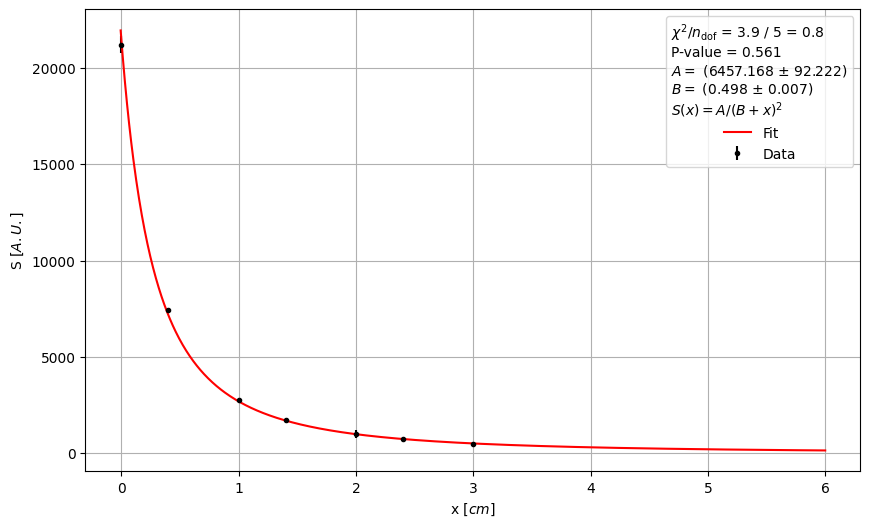

Intensità: [21203.82357238  7412.68855125  2783.28724901  1708.38368107
   997.7769388    741.51780691   508.31792029]
Intensità err: [419.62724347 147.7987207  111.99520765 140.5601422  204.21742207
  17.26650366   7.18851438]
Spessori: [0.  0.4 1.  1.4 2.  2.4 3. ]

 Intensità trapezi: [21114.96730724095, 7386.395491780885, 2771.211476993255, 1703.3772471689913, 980.7701745279168, 737.6643798310339, 507.0696493901366]


In [16]:
'''

    FIT ASSORBIMENTO con 511KeV con mu=0

'''

def angolo_solido_func(x, A, B):
    return (A/(B+(x+0.05))**2)

spessori = np.array([0., 0.4, 1, 1.4, 2, 2.4, 3])
intensità = np.array(intensità_511KeV)
intensità_err = np.sqrt(np.array(err_intensità_511KeV)**2 + np.array(err_sistematico_511KeV)**2)

ls = LeastSquares(spessori, intensità, intensità_err, angolo_solido_func)
m = Minuit(ls, A=4000, B=0.75)
m.migrad()
m.hesse()
display(m)

# plot
x_axis = np.linspace(-0.005, 6, 1000)
y = angolo_solido_func(x_axis, m.values['A'], m.values['B'])
plt.subplots(figsize=(10, 6))
plt.errorbar(spessori, intensità, intensità_err, marker='.', linestyle='', color='black', label='Data', ecolor='black')
plt.plot(x_axis, y, color='red', label='Fit')
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {(m.fval/m.ndof):.1f}",]
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append(f'$A = $ ({m.values["A"]:.3f} $\\pm$ {m.errors["A"]:.3f})')
fit_info.append(f'$B = $ ({m.values["B"]:.3f} $\\pm$ {m.errors["B"]:.3f})')
fit_info.append('$S(x) = A/(B+x)^2$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid(True)
plt.xlabel('x $[cm]$')
plt.ylabel('S $[A.U.]$')
plt.show()
print(f'Intensità: {intensità}')
print(f'Intensità err: {intensità_err}')
print(f'Spessori: {spessori}')
print(f'\n Intensità trapezi: {intensità_trapz_511KeV}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.3048 (χ²/ndof = 0.1)     │              Nfcn = 152              │
│ EDM = 1.78e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   0.036   │   0.019   │            │            │         │         │       │
│ 1 │ A    │   7.2e3   │   0.5e3   │            │            │         │         │       │
│ 2 │ B    │   0.534   │   0.022   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │       mu        A        B │
├────┼────────────────────────────┤
│ mu │ 0.000356   8.4355   0.4e-3 │
│  A │   8.4355 2.11e+05   9.7237 │
│  B │   0.4e-3   9.7237 0.000473 │
└────┴────────────────────────────┘

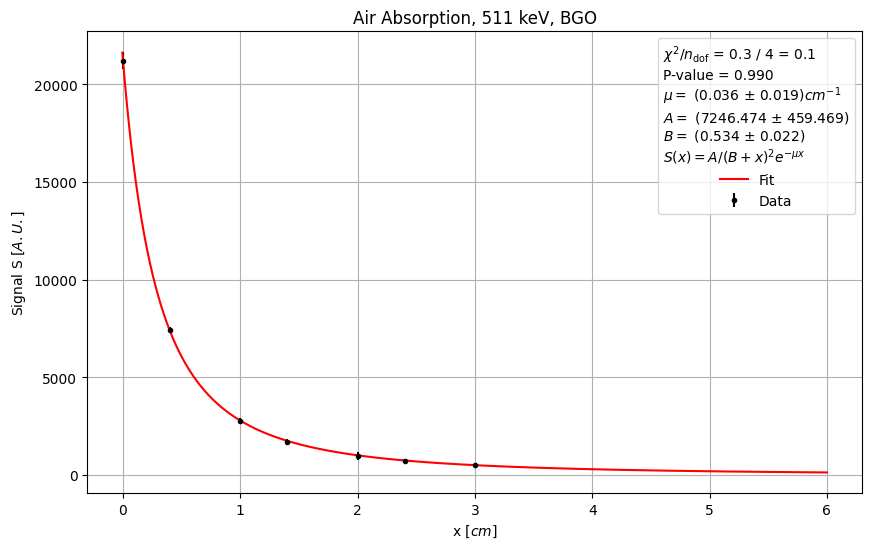

Coefficiente di assorbimento: 0.0355 ± 0.0189
Intensità: [21203.82357238  7412.68855125  2783.28724901  1708.38368107
   997.7769388    741.51780691   508.31792029]
Intensità err: [419.62724347 147.7987207  111.99520765 140.5601422  204.21742207
  17.26650366   7.18851438]
Spessori: [0.  0.4 1.  1.4 2.  2.4 3. ]

 Intensità trapezi: [21114.96730724095, 7386.395491780885, 2771.211476993255, 1703.3772471689913, 980.7701745279168, 737.6643798310339, 507.0696493901366]
Compatibilità con zero: 1.88 sigma


In [17]:
'''

    FIT ASSORBIMENTO con 511KeV con mu

'''

def assorbimento(x, mu, A, B):
    return (A/(B+(x+0.05))**2) * np.exp(-mu * x)

ls = LeastSquares(spessori, intensità, intensità_err, assorbimento)
m = Minuit(ls, mu=0.0001, A=4000, B=0.75)
m.migrad()
m.hesse()
display(m)

# plot
x_axis = np.linspace(-0.005, 6, 1000)
y = assorbimento(x_axis, m.values['mu'], m.values['A'], m.values['B'])
plt.subplots(figsize=(10, 6))
plt.errorbar(spessori, intensità, intensità_err, marker='.', linestyle='', color='black', label='Data', ecolor='black')
plt.plot(x_axis, y, color='red', label='Fit')
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {(m.fval/m.ndof):.1f}",]
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append(f'$\\mu = $ ({m.values["mu"]:.3f} $\\pm$ {m.errors["mu"]:.3f})' + '$cm^{-1}$')
fit_info.append(f'$A = $ ({m.values["A"]:.3f} $\\pm$ {m.errors["A"]:.3f})')
fit_info.append(f'$B = $ ({m.values["B"]:.3f} $\\pm$ {m.errors["B"]:.3f})')
fit_info.append('$S(x) = A/(B+x)^2 e^{- \mu x}$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid(True)
plt.title('Air Absorption, 511 keV, BGO')
plt.xlabel('x $[cm]$')
plt.ylabel('Signal S $[A.U.]$')
plt.show()
print(f'Coefficiente di assorbimento: {m.values["mu"]:.4f} ± {m.errors["mu"]:.4f}')
print(f'Intensità: {intensità}')
print(f'Intensità err: {intensità_err}')
print(f'Spessori: {spessori}')
print(f'\n Intensità trapezi: {intensità_trapz_511KeV}')
print(f'Compatibilità con zero: {m.values["mu"]/m.errors["mu"]:.2f} sigma')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.801 (χ²/ndof = 0.6)      │              Nfcn = 77               │
│ EDM = 1.24e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │    807    │    12     │            │            │         │         │       │
│ 1 │ B    │   0.604   │   0.007   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        A        B │
├───┼───────────────────┤
│ A │      156 79.23e-3 │
│ B │ 79.23e-3 5.17e-05 │
└───┴───────────────────┘

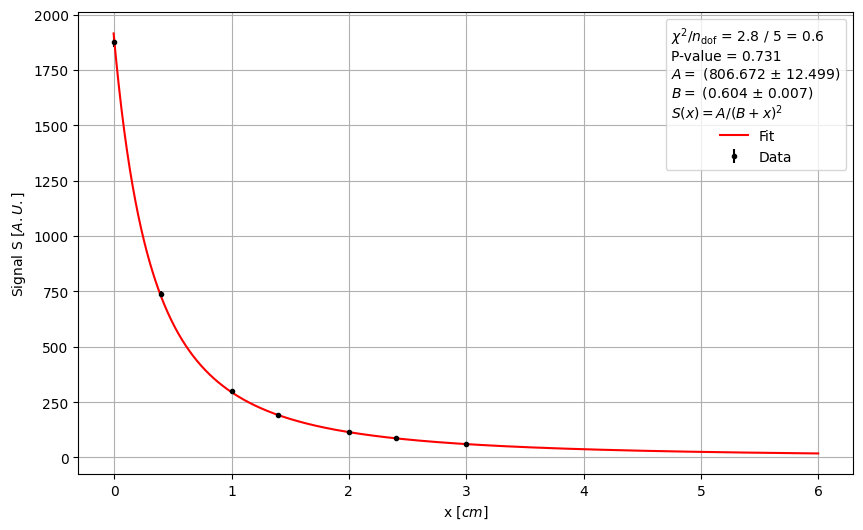

Intensità: [1877.38966207  737.21438718  298.7079544   191.85921196  112.79291107
   87.41870193   58.78978134]
Intensità err: [21.90826267 13.73520851  5.94595663  4.4414017   2.92402444  2.5687196
  1.56895877]
Spessori: [0.  0.4 1.  1.4 2.  2.4 3. ]


In [18]:
'''

    FIT ASSORBIMENTO con 1274.5KeV con mu=0

'''

intensità = np.array(intensità_1274_5KeV)
intensità_err = np.sqrt(np.array(err_intensità_1274_5KeV)**2 + np.array(err_sistematico_1274_5KeV)**2)

ls = LeastSquares(spessori, intensità, intensità_err, angolo_solido_func)
m = Minuit(ls, A=4000, B=0.75)
m.migrad()
m.hesse()
display(m)

# plot
x_axis = np.linspace(-0.005, 6, 1000)
y = angolo_solido_func(x_axis, m.values['A'], m.values['B'])
plt.subplots(figsize=(10, 6))
plt.errorbar(spessori, intensità, intensità_err, marker='.', linestyle='', color='black', label='Data', ecolor='black')
plt.plot(x_axis, y, color='red', label='Fit')
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {(m.fval/m.ndof):.1f}",]
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append(f'$A = $ ({m.values["A"]:.3f} $\\pm$ {m.errors["A"]:.3f})')
fit_info.append(f'$B = $ ({m.values["B"]:.3f} $\\pm$ {m.errors["B"]:.3f})')
fit_info.append('$S(x) = A/(B+x)^2$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid(True)
plt.xlabel('x $[cm]$')
plt.ylabel('Signal S $[A.U.]$')
plt.show()
print(f'Intensità: {intensità}')
print(f'Intensità err: {intensità_err}')
print(f'Spessori: {spessori}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.837 (χ²/ndof = 0.2)      │              Nfcn = 151              │
│ EDM = 6.23e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   0.026   │   0.018   │            │            │         │         │       │
│ 1 │ A    │    860    │    40     │            │            │         │         │       │
│ 2 │ B    │   0.627   │   0.019   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │        mu         A         B │
├────┼───────────────────────────────┤
│ mu │  0.000341 755.96e-3   0.31e-3 │
│  A │ 755.96e-3  1.86e+03 788.73e-3 │
│  B │   0.31e-3 788.73e-3  0.000347 │
└────┴───────────────────────────────┘

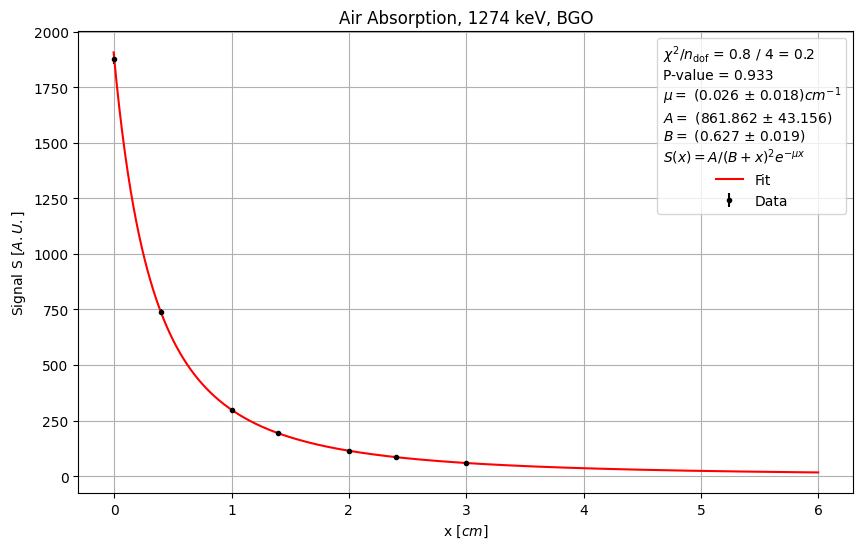

Coefficiente di assorbimento: 0.0258 ± 0.0185
Intensità: [1877.38966207  737.21438718  298.7079544   191.85921196  112.79291107
   87.41870193   58.78978134]
Intensità err: [21.90826267 13.73520851  5.94595663  4.4414017   2.92402444  2.5687196
  1.56895877]
Spessori: [0.  0.4 1.  1.4 2.  2.4 3. ]
Compatibilità con zero: 1.40 sigma


In [19]:
'''

    FIT ASSORBIMENTO con 1274.5KeV

'''

intensità = np.array(intensità_1274_5KeV)
intensità_err = np.sqrt(np.array(err_intensità_1274_5KeV)**2 + np.array(err_sistematico_1274_5KeV)**2)

ls = LeastSquares(spessori, intensità, intensità_err, assorbimento)
m = Minuit(ls, mu=0.001, A=4000, B=0.75)
m.migrad()
m.hesse()
display(m)

# plot
x_axis = np.linspace(-0.005, 6, 1000)
y = assorbimento(x_axis, m.values['mu'], m.values['A'], m.values['B'])
plt.subplots(figsize=(10, 6))
plt.errorbar(spessori, intensità, intensità_err, marker='.', linestyle='', color='black', label='Data', ecolor='black')
plt.plot(x_axis, y, color='red', label='Fit')
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {(m.fval/m.ndof):.1f}",]
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append(f'$\\mu = $ ({m.values["mu"]:.3f} $\\pm$ {m.errors["mu"]:.3f})' + '$cm^{-1}$')
fit_info.append(f'$A = $ ({m.values["A"]:.3f} $\\pm$ {m.errors["A"]:.3f})')
fit_info.append(f'$B = $ ({m.values["B"]:.3f} $\\pm$ {m.errors["B"]:.3f})')
fit_info.append('$S(x) = A/(B+x)^2 e^{- \mu x}$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid(True)
plt.title('Air Absorption, 1274 keV, BGO')
plt.xlabel('x $[cm]$')
plt.ylabel('Signal S $[A.U.]$')
plt.show()
print(f'Coefficiente di assorbimento: {m.values["mu"]:.4f} ± {m.errors["mu"]:.4f}')
print(f'Intensità: {intensità}')
print(f'Intensità err: {intensità_err}')
print(f'Spessori: {spessori}')
print(f'Compatibilità con zero: {m.values["mu"]/m.errors["mu"]:.2f} sigma')